First, we import all the necessary packages. Make sure all of them are installed

In [1]:
# Standard libraries
import os
import sys
import random
from pathlib import Path
from datetime import datetime

# Third-party libraries for data handling
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.color import gray2rgb
import cv2
import warnings

# Machine Learning and Deep Learning frameworks
import torch
import torchvision as tv
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.models import resnet18, resnet34, resnet50, ResNet50_Weights
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

# Training helpers
from torch.optim.lr_scheduler import MultiStepLR, CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
import pytorch_warmup as warmup
from torchmetrics import F1Score
from tqdm import tqdm, tqdm_notebook

# Visualization tools
import matplotlib.pyplot as plt

# Settings and configurations
torch.manual_seed(42)
#warnings.filterwarnings("ignore")  # Ignore warnings


We load the data and prepare to augment the images in the training set

In [2]:
# This was specified for compatability reasons with the challenge servers
train_mean = [0.59685254, 0.59685254, 0.59685254]
train_std = [0.16043035, 0.16043035, 0.16043035]

os.chdir('/Users/sebh/Desktop/GithubProjectDL/SolarPanel_defect_detection')

class ChallengeDataset(Dataset):
    
    def __init__(self, data, mode: str):
        self.data = data
        self.mode = mode

        self._transform_train = tv.transforms.Compose([
            tv.transforms.ToPILImage(), 
            tv.transforms.RandomHorizontalFlip(p=0.5),
            tv.transforms.RandomVerticalFlip(p=0.5),
            RandomRotate180(),
            tv.transforms.RandomAffine(degrees=0, translate=(0.02, 0.02)),
            tv.transforms.transforms.RandomRotation(degrees=(-3, 3)),
            #tv.transforms.RandomResizedCrop(300, scale=(0.98, 1.02)),
            tv.transforms.RandomEqualize(p=0.5),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(train_mean, train_std)
        ])
        
        self._transform_val = tv.transforms.Compose([
            tv.transforms.ToPILImage(), 
            tv.transforms.ToTensor(),
            tv.transforms.Normalize(train_mean, train_std)
        ])

    
    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):
        gray_img = imread(self.data.iloc[index]['filename'])

        # Convert the grayscale image to an RGB image and rearrange the dimensions for C, H, W
        rgb_img = torch.from_numpy(np.transpose(gray2rgb(gray_img), (2, 0, 1)))
        labels = torch.tensor([int(self.data.iloc[index]["crack"]), int(self.data.iloc[index]["inactive"])])

        if self.mode == 'train':
            img = self._transform_train(rgb_img)
        else:
            img = self._transform_val(rgb_img)

        return img, labels.float()
    

class RandomRotate180:
    def __init__(self, degrees=[0, 180]):
        self.degrees = degrees

    def __call__(self, img):
        degree = random.choice(self.degrees)
        return tv.transforms.functional.rotate(img, degree)
    
class Equalize(object):
    def __call__(self, img):
        return tv.transforms.functional.equalize(img)

Next, we create a Trainer() class that handles the forward pass, backward bass, checkpoint saving, tensorboard logging and metric calculations. For more informations you can read the README.md

In [3]:
mps_device = torch.device("mps")

class Trainer:

    def __init__(self,
                 model,                        # Model to be trained.
                 crit,                         # Loss function
                 optim=None,                   # Optimizer
                 scheduler=None,               # Scheduler for the LR
                 train_dl=None,                # Training data set
                 val_test_dl=None,             # Validation (or test) data set
                 cuda=True,                    # Whether to use the GPU
                 early_stopping_patience=-1):  # The patience for early stopping
        self._model = model
        self._crit = crit
        self._optim = optim
        self._scheduler = scheduler
        self._train_dl = train_dl
        self._val_test_dl = val_test_dl
        self._cuda = cuda

        self._early_stopping_patience = early_stopping_patience
        
        # set yor directory
        new_working_directory = "/Users/sebh/Desktop/GithubProjectDL/SolarPanel_defect_detection"
        os.chdir(new_working_directory)
        
        # Tensorboard logging and checkpoint save
        log_dir = f"runs/train_{datetime.now().strftime('%Y%m%d%H%M%S')}"
        self._writer = SummaryWriter(log_dir=log_dir)
    
        # change to cude if you do not want to train on apple silicon
        if cuda:
            # self._model = model.cuda()
            # self._crit = crit.cuda()
            self._model = model.to(mps_device)
            self._crit = crit.to(mps_device)
            
            #checkpoints
  
    def save_checkpoint(self, epoch):
        checkpoint_file = f"{self._writer.log_dir}/checkpoint_{epoch}.ckp"
        torch.save({'state_dict': self._model.state_dict()}, checkpoint_file)

    def restore_checkpoint(self, epoch_n):
        # specify the name (path) of the checkpoint you would like to load
        ckp = torch.load(f'runs/train_best2_load/checkpoint_{epoch_n}.ckp', map_location=torch.device('cpu'))
        self._model.load_state_dict(ckp['state_dict'])
        
    def save_onnx(self, fn):
        m = self._model.cpu()
        m.eval()
        x = torch.randn(1, 3, 300, 300, requires_grad=True)
        y = self._model(x)
        torch.onnx.export(m,             # model being run
              x,                         # model input (or a tuple for multiple inputs)
              fn,                        # where to save the model (can be a file or file-like object)
              export_params=True,        # store the trained parameter weights inside the model file
              opset_version=10,          # the ONNX version to export the model to
              do_constant_folding=True,  # whether to execute constant folding for optimization
              input_names = ['input'],   # the model's input names
              output_names = ['output'], # the model's output names
              dynamic_axes={'input' : {0 : 'batch_size'},    # variable lenght axes
                            'output' : {0 : 'batch_size'}})


    def train_step(self, x, y):
        self._optim.zero_grad()

        self._model.train()
        self._train_dl.mode = "train"

        out = self._model(x)
        loss = self._crit(out, y)
        loss.backward()
        self._optim.step()

        return loss 

        
    def val_test_step(self, x, y):
        self._model.eval()

        with torch.no_grad():
            preds = self._model(x)
            loss = self._crit(preds, y)

        return loss, preds

        
    def train_epoch(self):
        running_loss = 0.0
        n_batches = 0
        self._model.train()
        self._train_dl.mode = "train"

        for inputs, labels in self._train_dl:
            
            #inputs, labels = (inputs.cuda(), labels.cuda()) if self._cuda else (inputs, labels)
            inputs, labels = (inputs.to(mps_device), labels.to(mps_device)) if self._cuda else (inputs, labels)
            
            # Transfer the batch to the GPU if it's available
            #inputs = inputs.to(self._cuda) #specify mps device later
            #labels = labels.to(self._cuda)

            loss = self.train_step(inputs, labels)
            running_loss += loss

            n_batches += 1


        for scheduler in self._scheduler:
            scheduler.step()

        #self._scheduler.step()
        avg_loss = running_loss / n_batches

        self._writer.add_scalar('Loss/train', avg_loss, self.epoch_counter)
        
        return avg_loss
    
    def val_test(self):
        pred_list = []
        label_list = []
        running_loss = 0

        self._model.eval()
        self._val_test_dl.mode = "val"

        with torch.no_grad():
            for inputs, labels in self._val_test_dl:
                #inputs, labels = (inputs.cuda(), labels.cuda()) if self._cuda else (inputs, labels)
                inputs, labels = (inputs.to(mps_device), labels.to(mps_device)) if self._cuda else (inputs, labels)
                
                # transfer the batch to the gpu if given
                label_list.append(labels.cpu().numpy())
    
                loss, preds = self.val_test_step(inputs, labels)
                pred_list.append(np.around(preds.cpu().numpy()))

                running_loss += loss

        return self.loss_metrics(running_loss, np.array(pred_list), np.array(label_list))


    def loss_metrics(self, sum_loss, out_pred, out_true):
        # calculate the average loss and average metrics of your choice. 
        # You might want to calculate these metrics in designated functions

        # calculate average loss
        avg_loss = sum_loss / len(self._val_test_dl)

        #calculate the F1 score here
        f1_crack = f1_score(out_pred[:, :, 0].flatten(), out_true[:, :, 0].flatten(), average='binary') # indexing might be wrong
        f1_inactive = f1_score(out_pred[:, :, 1].flatten(), out_true[:, :, 1].flatten(), average='binary')
        f1_mean = (f1_crack + f1_inactive) / 2

        # log everything to tensorboard
        self._writer.add_scalar('Loss/val', avg_loss, self.epoch_counter)  # log the validation loss to TensorBoard
        self._writer.add_scalar('F1Score/Average', f1_mean, self.epoch_counter)  # log the average F1 score to TensorBoard
        self._writer.add_scalar('F1Score/Crack', f1_crack, self.epoch_counter)  # log the F1 score for "crack" to TensorBoard
        self._writer.add_scalar('F1Score/Inactive', f1_inactive, self.epoch_counter)  # log the F1 score for "inactive" to TensorBoard
        self._writer.add_scalar('LR', self._optim.param_groups[0]['lr'], self.epoch_counter)

        return avg_loss, f1_mean, f1_crack, f1_inactive

    def fit(self, epochs=-1):
        
        # Commented out to prevent restoring from a checkpoint
        # specify epoch number from which you want to restore the model's state.
        # You can only restore from epochs that you saved!
        #self.restore_checkpoint(7)
        
        assert self._early_stopping_patience > 0 or epochs > 0
        self.epoch_counter = 0
        train_loss = []
        val_loss = []
        f1_val_avg = []
        f1_val_crack = []
        f1_val_inactive = []
        
        # Initialize best_loss to inf and patience_counter to 0
        best_loss = np.inf
        patience_counter = 0

        while True:
            if self.epoch_counter == epochs:
                break

            train_loss.append(self.train_epoch())
            avg_loss, f1_mean, f1_crack, f1_inactive = self.val_test()

            #self._scheduler.step(avg_loss)
            val_loss.append(avg_loss)
            f1_val_avg.append(f1_mean)
            f1_val_crack.append(f1_crack)
            f1_val_inactive.append(f1_inactive)

            print ('--------------', self.epoch_counter, '--------------')
            print('val_loss:', val_loss[-1].item())
            print('f1_mean', f1_val_avg[-1])
            print('f1_crack', f1_val_crack[-1])
            print('f1_inactive', f1_val_inactive[-1])
            
            # Early stopping check
            if avg_loss < best_loss:
                best_loss = avg_loss
                patience_counter = 0
                # Save the best model so far
                self.save_checkpoint(self.epoch_counter)
            else:
                patience_counter += 1
                if patience_counter >= self._early_stopping_patience:
                    print("Early stopping due to no improvement after", self._early_stopping_patience, "epochs.")
                    break

            self.epoch_counter += 1

        self.save_checkpoint(self.epoch_counter)

        self._writer.close()

        return train_loss[-1], val_loss[-1]

Next, we need to do some oversampling of the minority class (undersample the majority class) to get a more balanced dataset and improve training. To do this, we need to first encode the labels as integers for RandomOverSampler() to work. After, we split the data into train, test and validation sets.

In [ ]:
# load the data from the csv file
data = pd.read_csv('/Users/sebh/Developer/Pytorch_Challenge/src_to_implement/data.csv', sep=';')
data['class'] = data['crack'].astype(str) + data['inactive'].astype(str)

# Encode class labels to integers
le = LabelEncoder()
data['class_encoded'] = le.fit_transform(data['class'])

# Separate features and target
X = data[['filename']]
y = data['class_encoded']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform oversampling on the training data
ros = RandomOverSampler(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# After resampling, you can split the 'class_encoded' back into the original columns if needed
y_train_res_df = pd.DataFrame(y_train_res, columns=['class_encoded'])
y_train_res_df['class'] = le.inverse_transform(y_train_res_df['class_encoded'])
y_train_res_df[['crack', 'inactive']] = pd.DataFrame(y_train_res_df['class'].str.extract('(\d)(\d)').values.tolist(), dtype=int)
train_set = pd.concat([X_train_res, y_train_res_df[['crack', 'inactive']]], axis=1)

# Transform y_test back into the original columns
y_test_df = pd.DataFrame(y_test, columns=['class_encoded'])
y_test_df['class'] = le.inverse_transform(y_test_df['class_encoded'])
y_test_df[['crack', 'inactive']] = y_test_df['class'].str.split("", n=2, expand=True)[[1,2]].astype(int)
val_set = pd.concat([X_test, y_test_df[['crack', 'inactive']]], axis=1)

# Set up data loading for the training and validation set each using DataLoader and ChallengeDataset objects
train_data = DataLoader(ChallengeDataset(train_set, 'train'), batch_size=16, shuffle=True)
test_data = DataLoader(ChallengeDataset(val_set, 'val'), batch_size=16, shuffle=True)

We can display some augmented images to see what we are feeding into our model. This also serves as a qick sanity check if our augmentations make sense for the data at hand.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


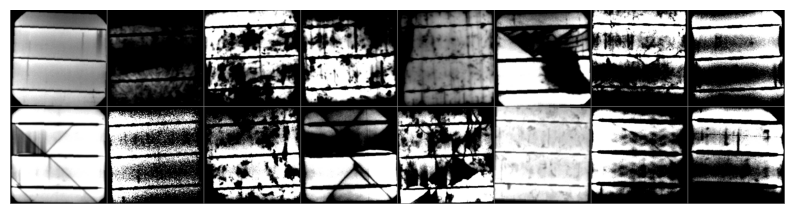

In [5]:
def imshow(img):
    plt.figure(figsize=(10, 8))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Remove the axes
    #plt.savefig('augmented_image_sample', dpi=800, bbox_inches='tight')  # uncomment for saving
    plt.show()


# Create data iterator
dataiter = iter(train_data)

# Get some random training images
images, labels = next(dataiter)

# Show images
imshow(tv.utils.make_grid(images))


We initialize a pretrained model. We can use any resnet model here (resnet18, resnet50, etc.). Resnet34 seems to perform best after tweaking the hyperparameters.

The tensorboard logs and and checkpoint files will be automatically saved into the '/runs' folder. 

**Note:** The hyperparameters below are **not** the optimal parameters. To get optimal performance, we need to optimize the lr (learning rate), weight_decay and lr_scheduler hyperparamters. This is only meant as a starting point.


In [7]:
# create an instance of our ResNet model
model = resnet34(weights='DEFAULT') 

# make sure the parameters are trainable
for param in model.parameters():
    param.requires_grad = True

model.fc = torch.nn.Sequential(torch.nn.Linear(512,2),
                               torch.nn.Sigmoid())


loss_fn = torch.nn.BCELoss()

#set up the optimizer
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.003, 
                            momentum=0.9,
                            nesterov=False,
                            weight_decay=0.0001)

# scheduler
scheduler = MultiStepLR(optimizer, 
                        milestones=[3, 10, 15, 17, 20], 
                        gamma=0.3) 
scheduler2 = MultiStepLR(optimizer, 
                        milestones=[5,70], 
                        gamma=0.5)


# create an object of type Trainer and set its early stopping criterion
trainer = Trainer(model, loss_fn, optimizer, [scheduler, scheduler2], train_data, test_data, True, 20)
# TODO

# go, go, go... call fit on trainer
res = trainer.fit(epochs = 5)

-------------- 0 --------------
val_loss: 0.29200291633605957
f1_mean 0.7139411804113351
f1_crack 0.6482213438735178
f1_inactive 0.7796610169491525
-------------- 1 --------------
val_loss: 0.21298499405384064
f1_mean 0.7357083678541839
f1_crack 0.8235294117647058
f1_inactive 0.647887323943662
-------------- 2 --------------
val_loss: 0.17646706104278564
f1_mean 0.8242521367521367
f1_crack 0.7596153846153845
f1_inactive 0.8888888888888888
-------------- 3 --------------
val_loss: 0.1230107992887497
f1_mean 0.8645299145299146
f1_crack 0.8444444444444446
f1_inactive 0.8846153846153846
-------------- 4 --------------
val_loss: 0.1109461858868599
f1_mean 0.8528922180607574
f1_crack 0.8539325842696629
f1_inactive 0.8518518518518519
